# Data Load

In [1]:
!wget https://drive.google.com/uc?id=1NWYqJgeG_4883LINdEjKUr6nLQPY6Yb_ -O data.txt

--2023-08-01 13:51:57--  https://drive.google.com/uc?id=1NWYqJgeG_4883LINdEjKUr6nLQPY6Yb_
Resolving drive.google.com (drive.google.com)... 64.233.170.138, 64.233.170.113, 64.233.170.102, ...
Connecting to drive.google.com (drive.google.com)|64.233.170.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-00-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/iaoc74lduqensa4k2r5lnsdnhbcub71o/1690897875000/16549096980415837553/*/1NWYqJgeG_4883LINdEjKUr6nLQPY6Yb_?uuid=e4e49df1-fc21-475d-9d10-d7a93a19df26 [following]
--2023-08-01 13:52:00--  https://doc-14-00-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/iaoc74lduqensa4k2r5lnsdnhbcub71o/1690897875000/16549096980415837553/*/1NWYqJgeG_4883LINdEjKUr6nLQPY6Yb_?uuid=e4e49df1-fc21-475d-9d10-d7a93a19df26
Resolving doc-14-00-docs.googleusercontent.com (doc-14-00-docs.googleusercontent.com)... 172.253.118.132, 2404:6800:4003:c05::84
Connecting to doc-1

https://huggingface.co/datasets/cointegrated/ru-paraphrase-NMT-Leipzig

In [2]:
!pip install -q youtokentome datasets

In [3]:
import datasets
data = datasets.load_dataset(
    'cointegrated/ru-paraphrase-NMT-Leipzig',
    data_files={"train": "train.csv","val": "val.csv","test": "test.csv"},
)

# Import

In [4]:
from youtokentome import BPE

In [5]:
import pandas as pd
import nltk
from collections import Counter
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [6]:
from IPython.display import clear_output

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingLR

In [8]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Dataset

In [9]:
df = pd.DataFrame()
df['en'] = data['train']['en']
df['ru'] = data['train']['original']
df = df.dropna().reset_index(drop=True)

In [10]:
# df = pd.read_csv('data.txt', sep='\t', names=['en', 'ru'])
# df['en'] = df['en'].apply(str)
# df['ru'] = df['ru'].apply(str)

In [11]:
len(df)

979994

In [12]:
class YandexDataset(Dataset):
    def __init__(self, src: list, trg: list):
        self.src = src
        self.trg = trg

    def __getitem__(self, index):
        return {
            'src': self.src[index],
            'trg': self.trg[index],
        }

    def __len__(self):
        return len(self.src)

In [13]:
df['en'] = df['en'].apply(
    lambda item: item.lower()
).apply(
    lambda item: '<sos> ' + item + ' <eos>'
)

In [14]:
df['ru'] = df['ru'].apply(
    lambda item: item.lower()
).apply(
    lambda item: '<sos> ' + item + ' <eos>'
)

In [15]:
df['en'].to_csv('data_en.csv', index=False)
df['ru'].to_csv('data_ru.csv', index=False)

In [16]:
%%time
en_bpe = BPE.train(data="data_en.csv", vocab_size=20000, model="en_bpe.bin")
ru_bpe = BPE.train(data="data_ru.csv", vocab_size=45000, model="en_bpe.bin")

CPU times: user 26 s, sys: 2.82 s, total: 28.8 s
Wall time: 22.8 s


In [17]:
encoded = en_bpe.encode('<sos> hello friend! <eos>')
tokenized = ""
for word in encoded:
    tokenized += " " + en_bpe.id_to_subword(word)
tokenized

' ▁<sos> ▁hello ▁friend ! ▁<eos>'

In [18]:
src = df['en'].apply(
    en_bpe.encode
).values.tolist()

In [19]:
src[0]

[290,
 7955,
 312,
 247,
 1058,
 266,
 558,
 3277,
 3744,
 275,
 247,
 651,
 1973,
 382,
 300,
 4529,
 355,
 247,
 18006,
 853,
 25,
 3277,
 7007,
 252]

In [20]:
trg = df['ru'].apply(
    ru_bpe.encode
).values.tolist()

In [21]:
dict(zip(src[11][::-1], trg[11]))

{252: 543,
 6175: 10365,
 266: 632,
 11095: 2789,
 9909: 653,
 275: 8915,
 6441: 35327,
 346: 660,
 7048: 500,
 3610: 6739,
 11649: 16504,
 8369: 8649,
 1601: 1746,
 16746: 22771,
 1507: 52,
 434: 33585,
 3549: 501,
 4229: 11800,
 5836: 22972,
 290: 11479}

In [22]:
src_train, src_test, trg_train, trg_test = train_test_split(
    src[:],
    trg[:],
    random_state=42,
    test_size=0.25
)
src_train, src_valid, trg_train, trg_valid = train_test_split(
    src_train,
    trg_train,
    random_state=42,
    test_size=0.2
)

In [23]:
len(src_train), len(src_valid), len(src_test)

(587996, 146999, 244999)

In [24]:
train_data = YandexDataset(src_train, trg_train)
valid_data = YandexDataset(src_valid, trg_valid)
test_data = YandexDataset(src_test, trg_test)

In [25]:
def collate_fn(batch):
    max_src_len = max(len(row["src"]) for row in batch)
    max_trg_len = max(len(row["trg"]) for row in batch)
    max_len = max(max_src_len, max_trg_len)
    src_list = torch.empty((len(batch), max_len), dtype=torch.long)
    trg_list = torch.empty((len(batch), max_len), dtype=torch.long)

    for idx, row in enumerate(batch):
        to_pad_src = max_len - len(row["src"])
        to_pad_trg = max_len - len(row["trg"])
        _src = row['src']
        _trg = row['trg']
        src_list[idx] = torch.cat((torch.tensor(_src), torch.zeros(to_pad_src)))
        trg_list[idx] = torch.cat((torch.tensor(_trg), torch.zeros(to_pad_trg)))

    return {
        'src': src_list,
        'trg': trg_list,
    }

In [26]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_data, batch_size=64, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, collate_fn=collate_fn)

In [27]:
for batch in train_loader:
    print(batch['src'].shape)
    print(batch['trg'].shape)
    break

torch.Size([64, 57])
torch.Size([64, 57])


In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [29]:
batch['src']

tensor([[ 290, 2122, 2854,  ...,    0,    0,    0],
        [ 290,  678,  301,  ...,    0,    0,    0],
        [ 290,  247, 1743,  ...,    0,    0,    0],
        ...,
        [ 290, 2087,  485,  ...,    0,    0,    0],
        [ 290,  543,  279,  ...,    0,    0,    0],
        [ 290, 4096,  708,  ...,  419,   22,  252]])

In [30]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Model

In [31]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self,
                 hid_dim: int,
                 n_heads: int,
                 dropout: float = 0.2,
                 device: str = 'cpu'
                 ):
        super().__init__()
        self.device = device
        if hid_dim % n_heads != 0:
            raise NotImplementedError

        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads

        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)

        self.fc_o = nn.Linear(hid_dim, hid_dim)

        self.dropout = nn.Dropout(p=dropout)
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(self.device)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)

        # query = [batch_size, query_len, hid_dim]
        # key = [batch_size, key_len, hid_dim]
        # value = [batch_size, value_len, hid_dim]

        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)

        # Q = [batch_size, query_len, hid_dim]
        # K = [batch_size, key_len, hid_dim]
        # V = [batch_size, value_len, hid_dim]

        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

        # Q = [batch_size, n_heads, query_len, head_dim]
        # K = [batch_size, n_heads, key_len, head_dim]
        # V = [batch_size, n_heads, value_len, head_dim]

        energy = torch.matmul(Q, K.transpose(2, 3)) / self.scale

        # energy = [batch_size, n_heds, query_len, key_len]

        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)

        attn = torch.softmax(energy, dim=-1)

        # attn = [batch_size, n_heds, query_len, key_len]

        x = torch.matmul(self.dropout(attn), V)

        # x = [batch_size, n_heads, query_len, head_dim]

        x = x.permute(0, 2, 1, 3).contiguous()

        # x = [batch_size, query_len, n_heads, head_dim]

        x = x.view(batch_size, -1, self.hid_dim)

        # x = [batch_size, query_len, hid_dim]

        x = self.fc_o(x)

        return x, attn

In [32]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self,
                 hid_dim: int,
                 pf_dim: int,
                 dropout: float = 0.2,
                 ):
        super().__init__()
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
      # x = [batch_size, seq_len, hid_dim]
      x = self.dropout(F.leaky_relu(self.fc_1(x)))

      # x = [batch_size, seq_len, pf_dim]
      x = self.fc_2(x)

      # x = [batch_size, seq_len, hid_dim]
      return x

In [33]:
class EncoderLayer(nn.Module):
    def __init__(self,
                 hid_dim: int,
                 n_heads: int,
                 pf_dim: int,
                 dropout: float = 0.2,
                 device: str = 'cpu',
                 ):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_ff = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, src, src_mask):
        # src = [batch_size, src_len, hid_dim]
        # src_mask = [batch_size, 1, 1, src_len]

        # self_attention
        _src, _ = self.self_attention(src, src, src, src_mask)

        # dropout / residual conn / layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))

        # src = [batch_size, src_len, hid_dim]

        # positionwise feedforward
        _src = self.positionwise_ff(src)

        # dropout / residual conn / layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))

        # src = [batch_size, src_len, hid_dim]

        return src

In [34]:
class Encoder(nn.Module):
    def __init__(self,
                 vocab_size: int,
                 hid_dim: int,
                 n_layers: int,
                 n_heads: int,
                 pf_dim: int,
                 max_length: int = 100,
                 dropout: float = 0.2,
                 device: str = 'cpu',
                ):
        super().__init__()

        self.device = device

        self.tok_embedding = nn.Embedding(vocab_size, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)

        self.layers = nn.ModuleList([
            EncoderLayer(
                hid_dim,
                n_heads,
                pf_dim,
                dropout,
                device,
            ) for _ in range(n_layers)
        ])

        self.dropout = nn.Dropout(p=dropout)
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(self.device)

    def forward(self, src, src_mask):
        # src = [batch_size, seq_len]
        # src_mask = [batch_size, 1, 1, src_len]

        batch_size = src.size(0)
        src_len = src.size(1)

        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        # pos = [batch_size, src_len]

        src = self.dropout(
            self.tok_embedding(src) * self.scale + self.pos_embedding(pos)
        )

        for layer in self.layers:
            src = layer(src, src_mask)

        # src = [batch_size, src_len, hid_dim]

        return src

In [35]:
encoder = Encoder(
    vocab_size=en_bpe.vocab_size(),
    hid_dim=256,
    n_layers=3,
    n_heads=8,
    pf_dim=512,
    max_length=256,
    dropout=0.2,
    device=device,
)

In [36]:
class DencoderLayer(nn.Module):
    def __init__(self,
                 hid_dim: int,
                 n_heads: int,
                 pf_dim: int,
                 dropout: float = 0.2,
                 device: str = 'cpu',
                 ):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)

        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_ff = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, trg, enc_src, trg_mask, src_mask):
        # trg = [batch_size, trg_len]
        # enc_src = [batch_size, src_len, hid_dim]
        # trg_mask = [batch_size, 1, trg_len, trg_len]
        # src_mask = [batch_size, 1, 1, src_len]

        # self_attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)

        # dropout / residual conn / layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))

        # trg = [batch_size, trg_len, hid_dim]

        # encoder_attention
        _trg, attn = self.encoder_attention(trg, enc_src, enc_src, src_mask)

        # dropout / residual conn / layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))

        # trg = [batch_size, trg_len, hid_dim]

        # positionwise feedforward
        _trg = self.positionwise_ff(trg)

        # dropout / residual conn / layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))

        # trg = [batch_size, trg_len, hid_dim]
        # attn = [batch_size, n_heads, trg_len, src_len]

        return trg, attn

In [37]:
class Decoder(nn.Module):
    def __init__(self,
                 output_dim: int,
                 hid_dim: int,
                 n_layers: int,
                 n_heads: int,
                 pf_dim,
                 dropout: float = 0.2,
                 device: str = 'cpu',
                 max_length: int = 100,
                ):
        super().__init__()
        self.device = device

        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)

        self.layers = nn.ModuleList([
            DencoderLayer(
                hid_dim,
                n_heads,
                pf_dim,
                dropout,
                device,
            ) for _ in range(n_layers)
        ])

        self.fc_out = nn.Linear(hid_dim, output_dim)

        self.dropout = nn.Dropout(p=dropout)
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(self.device)

    def forward(self, trg, enc_src, trg_mask, src_mask):
        # trg = [batch_size, trg_len]
        # enc_src = [batch_size, src_len, hid_dim]
        # trg_mask = [batch_size, 1, trg_len, trg_len]
        # src_mask = [batch_size, 1, 1, src_len]

        batch_size = trg.size(0)
        trg_len = trg.size(1)

        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        # pos = [batch_size, trg_len]

        trg = self.dropout(
            self.tok_embedding(trg) * self.scale + self.pos_embedding(pos)
        )

        for layer in self.layers:
            trg, attn = layer(trg, enc_src, trg_mask, src_mask)

        # trg = [batch_size, trg_len, hid_dim]
        # attn = [batch_size, n_heads, trg_len, src_len]

        out = self.fc_out(trg)

        # out = [batch_size, trg_len, output_dim]

        return out, attn

In [38]:
decoder = Decoder(
    output_dim=ru_bpe.vocab_size(),
    hid_dim=256,
    n_layers=3,
    n_heads=8,
    pf_dim=512,
    dropout=0.2,
    device=device,
    max_length=256,
)

In [39]:
class Seq2Seq(nn.Module):
    def __init__(self,
                 encoder,
                 decoder,
                 src_pad_idx,
                 trg_pad_idx,
                 device,
                 ):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder

        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, src):
        # src = [batch_size, src_len]
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        # src_mask = [batch_size, 1, 1, src_len]
        return src_mask

    def make_trg_mask(self, trg):
        # trg = [batch_size, trg_len]
        trg_len = trg.size(1)

        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)

        # trg_pad_mask = [batch_size, 1, 1, trg_len]

        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device=self.device)).bool()

        # trg_sub_mask = [trg_len, trg_len]

        trg_mask = trg_pad_mask & trg_sub_mask
        # trg_mask = [batch_size, 1, trg_len, trg_len]

        return trg_mask


    def forward(self, src, trg):
        # src = [batch_size, seq_len]
        # trg = [batch_size, seq_len]

        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        # src_mask = [batch_size, 1, 1, seq_len]
        # trg_mask = [batch_size, 1, trg_len, trg_len]

        enc_src = self.encoder(src, src_mask)
        # enc_src = [batch_size, src_len, hid_dim]

        out, attn = self.decoder(trg, enc_src, trg_mask, src_mask)
        # out = [batch_size, trg_len, out_dim]
        # attn = [batch_size, n_heads, trg_len, src_len]

        return out, attn

In [40]:
model = Seq2Seq(encoder, decoder, 0, 0, device)
model.to(device)

Seq2Seq(
  (encoder): Encoder(
    (tok_embedding): Embedding(20000, 256)
    (pos_embedding): Embedding(256, 256)
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.2, inplace=False)
        )
        (positionwise_ff): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=256, out_features=512, bias=True)
          (fc_2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.2, inplace=False)
        )
       

In [41]:
output = model(batch['src'].to(device), batch['trg'].to(device))
output[0].shape, output[1].shape

(torch.Size([64, 57, 45000]), torch.Size([64, 8, 57, 57]))

In [42]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 32,289,736 trainable parameters


In [43]:
# model.to(device)

In [49]:
epochs = 3
PAD_IDX = 0
optimizer = optim.Adam(model.parameters(), lr=5e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=int(len(train_loader) + 1) * epochs)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [50]:
def train(model, iterator, optimizer, scheduler, criterion, clip, train_history=None, valid_history=None):
    model.train()

    epoch_loss = 0
    history = []
    i = 0
    for batch in tqdm(iterator):

        src = batch['src'].to(device)
        trg = batch['trg'].to(device)

        optimizer.zero_grad()

        output, _ = model(src, trg[:,:-1])

        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]

        output_dim = output.shape[-1]

        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)

        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]

        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()

            plt.show()
        i+=1

    return epoch_loss / len(iterator)


def evaluate(model, iterator, criterion):

    model.eval()

    epoch_loss = 0

    with torch.no_grad():

        for batch in tqdm(iterator):

            src = batch['src'].to(device)
            trg = batch['trg'].to(device)

            output, _ = model(src, trg[:,:-1])

            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]

            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)

            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

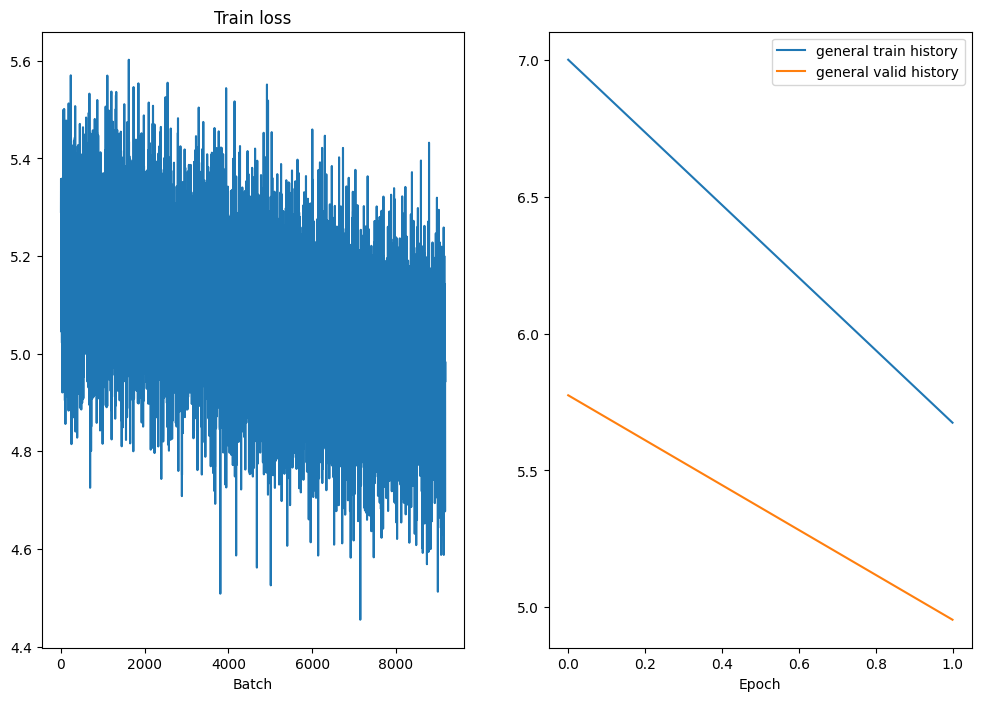

100%|██████████| 2297/2297 [01:56<00:00, 19.65it/s]


In [51]:
train_history = []
valid_history = []
for epoch in range(epochs):
    train_loss = train(model, train_loader, optimizer, scheduler, criterion, 2, train_history, valid_history)
    valid_loss = evaluate(model, valid_loader, criterion)

    train_history.append(train_loss)
    valid_history.append(valid_loss)

In [52]:
def remove_tech_tokens(tokens: list, bpe):
    result = []
    for token in tokens:
       if token not in [bpe.subword_to_id('▁<sos>'), bpe.subword_to_id('▁<eos>'), 0]:
          result.append(token)
    return result

In [53]:
batch = next(iter(test_loader))

for idx in range(10):
    src = batch['src'][idx:idx+1, :].to(device)
    trg = batch['trg'][idx:idx+1, :].to(device)

    model.eval()
    src_mask = model.make_src_mask(src)

    with torch.no_grad():
        enc_src = model.encoder(src, src_mask)

    trg_indexes = [ru_bpe.subword_to_id('▁<sos>'),]

    for i in range(100):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)

        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)

        pred_token = output.reshape(-1, ru_bpe.vocab_size()).argmax(1)[-1].item()

        trg_indexes.append(pred_token)

        if pred_token == ru_bpe.subword_to_id('▁<eos>'):
            break

    original = en_bpe.decode(remove_tech_tokens(src.cpu().numpy()[0].tolist(), en_bpe))
    generated = ru_bpe.decode(remove_tech_tokens(trg_indexes, ru_bpe))

    print(original)
    print(generated)
    print()


['the nights here are cold, and we are not thick-skinned enough not to freeze.']
['ночи здесь холодно, и мы не достаточно плотным и не достаточно многоцветным для того, чтобы не хватило.']

['development, support, promotion of sites.']
['разработка, продвижение сайтов.']

['this level controls the other six levels.']
['этот уровень контролирует шесть уровней.']

['the freedom to feel, to feel, to be sensual again, and the freedom to go beyond the mind.']
['свобода чувствовать себя чувствовать себя чувствовать себя и снова, чтобы идти в истине.']

['the trainee flew all ten metres, climbed over the railings and went down, but after ten seconds he came out of the air again right next to the portal.']
['в сторону все десять метрах от десяти метров, поднялся на рельсы и пошел через десять минут, но после этого он снова вышел на следующий этап в сторону прямо в сторону города.']

['in the morning i go to work on the first train, but return on the last one and have to walk along this tunnel 